Chargement des modules nécessaires

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ete3 import PhyloTree, TreeStyle, NodeStyle, TextFace

## ETL 
Création des données supplémentaire

In [1]:
!cat ./data/spike_data_708.fasta | grep ">" | sed "s/>//" > ./data/spike_header_cl.txt 

'cat' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.


In [3]:
!head -n 5 ./data/spike_header_cl.txt

QYV93424.1 surface glycoprotein [Severe acute respiratory syndrome coronavirus 2] | country "USA" | 2021-07-19
QYO33317.1 surface glycoprotein [Severe acute respiratory syndrome coronavirus 2] | country "USA" | 2021-07-26
QZM58781.1 surface glycoprotein [Severe acute respiratory syndrome coronavirus 2] | country "USA" | 2021-08-03
QZE52792.1 surface glycoprotein [Severe acute respiratory syndrome coronavirus 2] | country "USA" | 2021-08-02
QYP84224.1 surface glycoprotein [Severe acute respiratory syndrome coronavirus 2] | country "USA" | 2021-07-14


Importation des données supplémentaires

In [4]:
prot_names = []
prot_dates = []
prot_origin = []

with open("./data/spike_header_cl.txt", "r", encoding="utf8") as filein:
    for ligne in filein:
        l_spl = ligne.split("|")
        prot_names.append(l_spl[0].split()[0])
        prot_origin.append(l_spl[1].split('"')[1])
        prot_dates.append(l_spl[2])

# organiser as dataframe
spike_df = pd.DataFrame(data={"name": prot_names,
                              "origin": prot_origin,
                              "date": prot_dates})
spike_df["date"] = pd.to_datetime(spike_df["date"])
spike_df.index = spike_df["name"]
spike_df.head()

,name,origin,date
name,,,
QYV93424.1,QYV93424.1,USA,2021-07-19
QYO33317.1,QYO33317.1,USA,2021-07-26
QZM58781.1,QZM58781.1,USA,2021-08-03
QZE52792.1,QZE52792.1,USA,2021-08-02
QYP84224.1,QYP84224.1,USA,2021-07-14


Importation des données de l'arbre (comment on a fait)

In [5]:
tree_root = PhyloTree(newick="./data/nj_tree.nwk", format=1)

## Exploration du jeu de données

### Exploration de l'arbre

In [46]:
leaf_clo, dist_to_leaf = tree_root.get_closest_leaf()
print(f"La distance à la plus proche feuille {leaf_clo.name} est :"
      f" {dist_to_leaf}\n"
      f"Son origine est {spike_df.loc[leaf_clo.name]['origin']}, "
      f"sa date de séquençage est le {spike_df.loc[leaf_clo.name]['date']}")
leaf_far, dist_to_leaf_far = tree_root.get_farthest_leaf()
print(f"La distance à la plus lointaine feuille {leaf_far.name} est"
      f" : {dist_to_leaf_far}\n"
      f"Son origine est {spike_df.loc[leaf_far.name]['origin']},"
      f" sa date de séquençage est le {spike_df.loc[leaf_far.name]['date']}")

La distance à la plus proche feuille BCI48738.1 est : 0.001
Son origine est Australia, sa date de séquençage est le 2020-04-01 00:00:00
La distance à la plus lointaine feuille QJR94629.1 est : 0.04541
Son origine est Australia, sa date de séquençage est le 2020-04-03 00:00:00


### Exploration du jeu de séquences

In [34]:
print(f"Notre dataset possède {spike_df.shape[0]} séquences, que nous avons"
      " organisées en arbre.\n"
      "Les pays d'origine de ces séquences "
      f"sont {', '.join(set(spike_df['origin']))},"
      " mais la représentation n'est pas équilibrée "
      "entre ces différents pays")

Notre dataset possède 708 séquences, que nous avons organisées en arbre.
Les pays d'origine de ces séquences sont China, USA, Bangladesh, France, Lebanon, Georgia, Egypt, Russia, Germany, Ghana, Italy, Spain, Saudi Arabia, India, Australia, United Kingdom, Chile, Thailand, mais la représentation n'est pas équilibrée entre ces différents pays


In [9]:
spike_df["origin"].value_counts()

USA               651
Australia          21
India               9
Bangladesh          5
Egypt               4
Saudi Arabia        3
Spain               2
Germany             2
United Kingdom      2
Ghana               1
Lebanon             1
Thailand            1
China               1
Chile               1
France              1
Russia              1
Italy               1
Georgia             1
Name: origin, dtype: int64

## Cas d'étude : Australie

Etant donné le grand nombre de séquences dans nos données, afin de démontrer les capacités d'exploration et d'analyse des arbres, nous allons étudier un sous ensemble de nos données : les séquences provenant d'Australie. Nous allons obtenir un arbre de deux façons : la première en élaguant notre arbre (pruning), et la seconde en reconstruisant un arbre uniquement à partir des séquences australiennes.

### Pruning

In [10]:
list_austr = list(spike_df.index[spike_df["origin"] == "Australia"])

In [11]:
aus_t = tree_root
aus_t.prune(list_austr)

In [12]:
_ = aus_t.render("./img/austr_tree.png", dpi=600)

![Australian tree](./img/austr_tree.png)

On peut également afficher un titre, et représenter l'arbre de façon circulaire si l'envie nous prend : 

In [13]:
aus_ts = TreeStyle()
aus_ts.show_leaf_name = False
aus_ts.title.add_face(TextFace("Arbre Australien", fsize=20), column=0)
aus_ts.mode = "c"
aus_ts.arc_start = -180
aus_ts.arc_span = 180
a = aus_t.render("./img/aus_tree_circ.png", dpi=200, tree_style=aus_ts)

![Circular tree](./img/aus_tree_circ.png)

Dans les deux représentations, nous pouvons observe que la majorité des séquences sont très proches, même si 8 d'entre elles sont nettement plus loin.
Une des choses les plus intéressante serait de pouvoir distinguer nos feuilles par date. Tout d'abord, il est intéressant d'étudier la distribution des dates dans nos 21 séquences.

In [14]:
spike_df[spike_df["origin"] == "Australia"]["date"]\
        .describe(datetime_is_numeric=True)

count                               21
mean     2020-05-24 02:17:08.571428608
min                2020-03-19 00:00:00
25%                2020-03-31 00:00:00
50%                2020-06-12 00:00:00
75%                2020-07-05 00:00:00
max                2020-08-20 00:00:00
Name: date, dtype: object

Nous pouvons observer que les protéines spike du virus ont tous été séquencés entre mars et août 2020, et que 5 d'entre elles l'ont été en mars 2020. Nous pouvons essayer de représenter cette distribution en représentant la distribution cumulée des dates : 

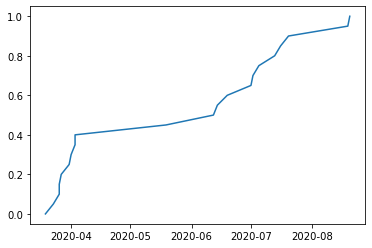

In [15]:
x = np.sort(spike_df[spike_df["origin"] == "Australia"]["date"])
y = np.linspace(0, 1, len(x))
plt.plot(x, y)
plt.savefig("cdf.png")

Mais il serait plus intéressant d'afficher directement sur l'arbre ces différentes dates : 

In [27]:
def color_by_date_med(tree, date_med, sequence_df):
    """Update the graphical caracteristics of an ete tree for a median date.

    Parameters
    ----------
    tree : TreeNode
        The tree to be modified
    date_med : datetime
        The median date to color with
    sequence_df : dataframe
        The dataframe containing date information

        Colors leaves of an ete tree depending on their position
        in relation to the median date : red before, blue after
    """
    for leaf in tree.iter_leaves():
        leaf.add_face(TextFace(str(sequence_df.loc[leaf.name, "date"])
                                .split()[0]), column=0)
        leaf_style = NodeStyle()
        if sequence_df.loc[leaf.name, "date"] <= date_med:
            leaf_style["bgcolor"] = "#ffbfbf"
        else:
            leaf_style["bgcolor"] = "#bfbfff"
        leaf.set_style(leaf_style)


date_med_aus = spike_df[spike_df["origin"] == "Australia"]\
                        ["date"].quantile(0.5)
color_by_date_med(aus_t, date_med_aus, spike_df)

In [17]:
_ = aus_t.render("./img/aus_tree_date.png", dpi=600)

![Arbre](./img/aus_tree_date.png)

Les regroupements visibles dans l'arbre semblent en partie correspondre à la date de séquençage. En effet, les deux groupes qui se dessinent contiennent tous deux des séquences de mars 2020. Il semble y en avoir un peu plus dans le groupe le plus détaché, malgré tout. En outre, le groupe le plus détaché possède une seule séquence de la seconde moitié de notre échantillon.

### Nouvel arbre
Grâce à notre script d'alignement, nous pouvons générer un arbre uniquement pour les séquences australiennes. Nous chargeons ensuite le résultat ici.

In [18]:
aus_t_new = PhyloTree(newick="./data/nj_tree_Australia.nwk", format=1)

Nous pouvons alors représenter l'arbre de la même façon que précédemment, afin de jauger graphiquement les ressemblances entre les deux arbres.

In [19]:
color_by_date_med(aus_t_new, date_med_aus, spike_df)
_ = aus_t_new.render("./img/aus_tree_new_date.png", dpi=300)

![Arbre des séquences australiennes, recalculé depuis les séquences](./img/aus_tree_new_date.png)

On observe un résultat sensiblement différent, au premier abord. Cependant, si l'on regarde de plus près, les séquences à une distance plus importante sont exactement les mêmes que dans l'arbre précédent. Nous pouvons donc penser que cet arbre a plus en commun avec le précédent qu'au premier regard. Mais comment en être certain?

La distance de Robinson-Foulds est une manière relativement simple de comparer deux arbres : fondamentalement, elle compare le nombre de partition des données du premier arbre non contenu dans le second, et inversement, et somme ces deux valeurs. Plus cette distance est élevée, plus ces deux arbres sont dissimilaires. 

In [20]:
aus_t.unroot()
results = aus_t.compare(aus_t_new, unrooted=True)

In [21]:
results["norm_rf"]

0.5555555555555556

On observe un distance plutôt importante : cependant, nous pouvons supposer que ceci est lié au fait que nombre de séquences qui le compose sont proches les unes des autres, et que le seul le sous groupe le plus éloigné est conservé entre deux. 

## Cas d'étude : les séquences les plus anciennes
Comme précédemment, nous utilisons notre dataframe pour récupérer une liste des séquences les plus anciennes de notre dataset. Nous allons ensuite y adjoindre la séquence référence du SARS-COV1 : cela nous permettra de démontrer les capacités d'enracinement d'ETE.

In [22]:
old_seq_t = PhyloTree(newick="./data/nj_tree_outgroup.nwk", format=1)

In [23]:
COV1 = "SARS_COV1"
for leaf in old_seq_t.iter_leaves():
    if leaf.name == COV1:
        leaf_style = NodeStyle()
        leaf_style["fgcolor"] = "#00c91b"
        leaf_style["bgcolor"] = "#788079"
        leaf_style["size"] = 7
        leaf.set_style(leaf_style)

In [24]:
_ = old_seq_t.render("./img/old_t_unroot.png", dpi=300)

![Arbre non enraciné](./img/old_t_unroot.png)

In [25]:
old_seq_t.set_outgroup(old_seq_t & "SARS_COV1")

In [26]:
_ = old_seq_t.render("./img/old_t_rooted.png", dpi=300)

![Arbre des séquences anciennes, enraciné](../img/old_t_rooted.png)